# Querying Prompts

### Using the attached dataset of throws to first base, please answer the following questions. Please utilize SQL, R or Python to aggregate the data. Attach all code and visualiza5ons that you used throughout your entire process.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- 1. Which 5 infielders had the quickest exchange times on throws to first base? 

In [3]:
data = pd.read_csv('./dataset_2024.csv')

# Infield position was not referenced explicitly so I assume fielder_position follows typical convention as referenced by this link 
# 
# https://en.wikipedia.org/wiki/Baseball_positions#/media/File:Baseball_positions.svg

# Get relevant columns
infielders = list(range(1, 7))
exchange_times = data[['exchange_time', 'thrower_id', 'fielder_position']].sort_values('exchange_time').dropna()


#Filter out non-infielders
exchange_times = exchange_times[exchange_times['fielder_position'].isin(infielders)]

# Get top 5 exchange_times
print(exchange_times[exchange_times['exchange_time'] > 0].head(5))


print('The infielders with the top 5 exchange times are: ', exchange_times[exchange_times['exchange_time'] > 0]['thrower_id'].head(5).values)

       exchange_time  thrower_id  fielder_position
5194           0.033           1                 1
10676          0.034         592                 2
10790          0.034         292                 1
12778          0.067         396                 5
3417           0.067         658                 1
The infielders with the top 5 exchange times are:  [  1 592 292 396 658]


- The infield coach wants to see which teams made the most errant throws to first base. An errant  throw is described as a throw that bounced and resulted in the runner being safe. Please create  a basic visual that you would present to the infield coach to present your findings. 


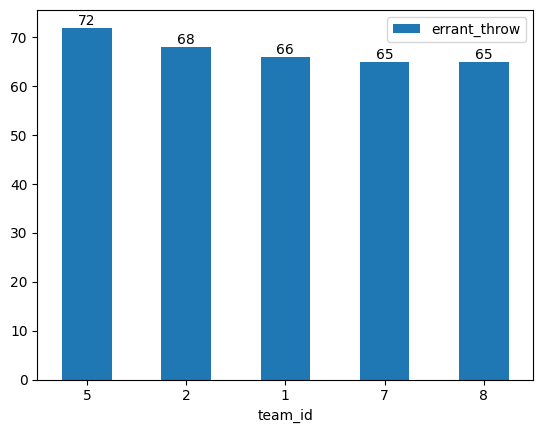

In [4]:
# Start by filtering for infielders
infielders = data[data['fielder_position'].isin(infielders)]

# Need to define errant throw so need the batter_result = 'first' and any 'bounce' column to not be NaN
data['errant_throw'] = np.where((data['batter_result'] == 'first') & (data['bounce_velo_y'].notnull()), 1, 0)

# Group by team_id and sum the errant_throw column
errant_throw_counts = data[['errant_throw', 'team_id']].groupby('team_id').sum().sort_values('errant_throw', ascending=False)

# Plot the bar graph
ax = errant_throw_counts.head(5).plot(kind='bar', rot=0)

# Add value counts at the top of each bar
for p in ax.patches:
    # This is just fancy syntax for centering the bar labels in case not familiar
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Display the plot
plt.show()


- Looking at all infield throws to first base, given that the distance of the throw to first base was in  the top 90th percentile, what team had the best average exchange time? Which team had the  largest variation in exchange time on these throws? 


<Axes: >

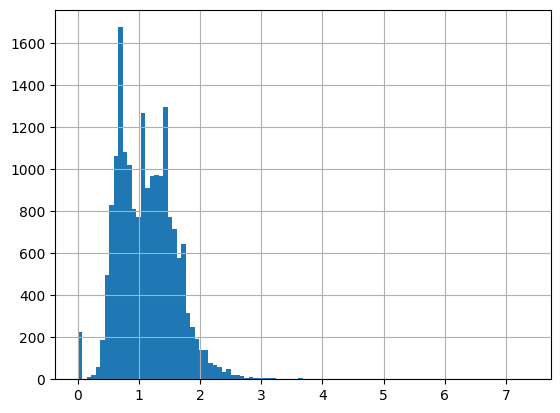

In [5]:
# Not really normally distributed so median is probably a better metric, but I will use both just for demonstration
infielders = list(range(1, 7))
infielder_df = data[data['fielder_position'].isin(infielders)]
infielder_df['exchange_time'].hist(bins=100)

In [11]:
# Get the values above the 90th percentile of distance from 1st base for infielders (have to do it backwards since further away from first base is negative)

infielders_90th_percentile = infielder_df[infielder_df['throw_pos_x'] < infielder_df['throw_pos_x'].quantile(.1)]

# Group by team_id and get the mean exchange_time..using mean and median to get a sense of the distribution
mean_teams = infielders_90th_percentile[['team_id', 'exchange_time']].groupby('team_id').mean().sort_values('exchange_time').head(5)
print(mean_teams)
median_teams = infielders_90th_percentile[['team_id', 'exchange_time']].groupby('team_id').median().sort_values('exchange_time').head(5)
print(median_teams)

overlapped_teams = set(mean_teams.index).intersection(set(median_teams.index))

print('The teams that appear in both the mean and median top 5 are: ', overlapped_teams)

[3]
         exchange_time
team_id               
9             1.159281
6             1.183465
15            1.199291
13            1.206894
2             1.227542
         exchange_time
team_id               
6                1.133
9                1.167
4                1.200
13               1.200
2                1.233
The teams that appear in both the mean and median top 5 are:  {9, 2, 13, 6}


In [11]:
#Using overlapped teams we can calculate the variance in ther exchange_time
variance = infielders_90th_percentile[infielders_90th_percentile['team_id'].isin(overlapped_teams)][['team_id', 'exchange_time']].groupby('team_id').var()
print(variance.sort_values('exchange_time', ascending=False).head(5))
print('The team with the highest variance in exchange_time is Team', variance.sort_values('exchange_time', ascending=False).head(1).index.values[0])

         exchange_time
team_id               
9             0.152465
13            0.138362
2             0.115110
6             0.107431
The team with the highest variance in exchange_time is Team 9


- 5. Given that a throw was made less than 100 feet from first base, is there a correlation between  throw velocity and throw distance? Provide a basic visual alongside a brief explanation.

    - This is kind of tricky because we are not given the position of first base, I just know that the receiver was always the first baseman

    - Maybe I am overcomplicating it but I believe the best way to figure this out would be to come up with some sort of proxy for the location of 1st base and then decide based on the x-coordinate which throws were within 100ft of that position

    - I know the receiever_x_pos, I know the receiver is always the 1st baseman, and I know the receiver_dist_from_1b...so I will add the receiver distance from first base to the receiver_pos_x since I know the greater number is towards first place_dugout....but that won't neccesarily work since the first baseman may have receieved the ball closer to the dugout and then moved negative on the x-coordinate towards first base....hmmm. Lets see what I can come up wtih

In [20]:
data['receiver_pos_x'].describe()

count    19968.000000
mean        59.332898
std         10.797400
min        -61.082994
25%         60.058868
50%         60.874737
75%         61.670060
max        171.003787
Name: receiver_pos_x, dtype: float64

- Actually, frankly, all the data basically lines up at one location (there seem to be some bizarre outliers) so i will just use the median as the position of first base for simplicity

<Axes: xlabel='throw_velo_x', ylabel='throw_pos_x'>

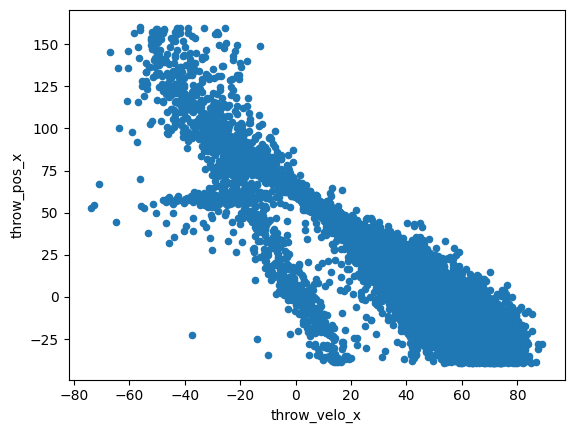

In [24]:
first_base_x_location = data['receiver_pos_x'].describe()['50%']

#Get all throws less than 100 ft from 1st base
final_df = data[abs(data['throw_pos_x'] - first_base_x_location) <= 100]

#Focusing on X-direction for simplicity sake
final_df[['throw_velo_x', 'throw_pos_x']].plot(kind='scatter', x='throw_velo_x', y='throw_pos_x')

- Seems like a nice pretty linear relationship between balls thrown further away from home plate towards third-base dugout (negative throw-pos-x) and throw-velocity which intuitively makes sense. 

- A throw further away from home base needs to be thrown harder

<Axes: xlabel='throw_velo_x', ylabel='throw_pos_x'>

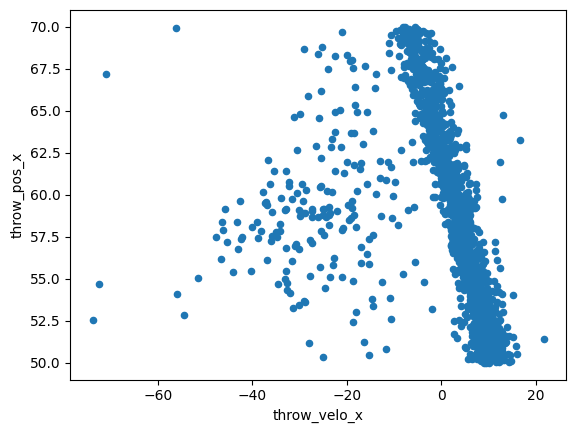

In [27]:
final_df[(final_df['throw_pos_x'] >= 50) & (final_df['throw_pos_x'] <= 70)][['throw_velo_x', 'throw_pos_x']].plot(kind='scatter', x='throw_velo_x', y='throw_pos_x')


- When getting really close to first base you start to see a ton of variation compared to within 100ft

In [25]:
final_df[['throw_velo_x', 'throw_pos_x']].corr().style.background_gradient(cmap='coolwarm')

,throw_velo_x,throw_pos_x
throw_velo_x,1.000000,-0.917975
throw_pos_x,-0.917975,1.000000


- Strong negative correlation betwwen the throw_pos_x and throw_velocity_x for throws within 100ft of first base

- Perhaps less of correlation on throws very close to first but overall definetly a correlation